## Processing of imaging data using max-projection (i.e. data compressed to 3D)
Note that this preprocessing pipeline can be used to process  single-plane imaging data (3D) or volume imaging data (4D). In the latter case, the volume is collapsed through a max projection.

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

#### Set paths to data files and plot directory

In [9]:
rootDir = '../../../../data_unityvr/'
subdir = 'gradientTest'
dataDir = sep.join([rootDir, 'raw',subdir,'SS96_x_7f/EB/f01'])
rawTiff = 'SS96-x-7f_f01_5-6d_EB_gradC1_00001.tif'
plotDir = sep.join([rootDir, 'plot',subdir, sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', subdir, sep.join(dataDir.split(sep)[-4:])])

genotype = '-'.join(rawTiff.split('_')[0:3])
[flyID, region] = rawTiff.split('_')[3:5]
condition = rawTiff.split('_')[-2]
trial = "trial"+rawTiff.split('_')[-1][3:-4]
print('Genotype: {}, Imaging region: {}, Fly id: {}\nCondition: {}, Trial: {}'.format(
    genotype, region, flyID, condition, trial))

Genotype: SS96-x-7f-f01-5-6d, Imaging region: gradC1, Fly id: EB
Condition: gradC1, Trial: trial01


In [10]:
# Generate directory where to save plots
saveDir = sep.join([plotDir]) #condition
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

../../../../data_unityvr//plot/gradientTest/gradientTest/SS96_x_7f/EB/f01
../../../../data_unityvr//preproc/gradientTest/gradientTest/SS96_x_7f/EB/f01


#### Load data and perform motion correction

In [11]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


In [12]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

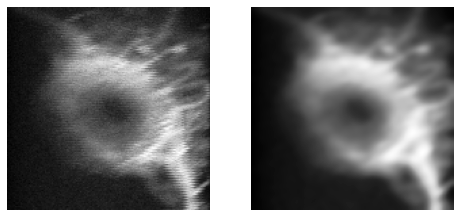

In [13]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [14]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

TypeError: motionCorrection() takes 2 positional arguments but 4 were given

#### Compute DFF

In [ ]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

***Specify region for background subtraction***
* Paint a small region named "background" using a brush in the Labels menu in the napari gui. This region should not overlap with the intended signal roi.
* If there is an existing mask placed in the preprocessing folder of the fly and/or tiral, it will be loaded automatically
* If subtracting using rolling ball, skip the next 2 cells

In [ ]:
# you can draw a mask on the foreground
viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])

if exists(sep.join([preprocDir,condition,'background.npy'])):
    background = np.load(sep.join([preprocDir,condition,'background.npy'])) 
    viewer.add_labels(background, name='background')
    
elif exists(sep.join([preprocDir,'background.npy'])):
    
    background = np.load(sep.join([preprocDir,'background.npy']))
    viewer.add_labels(background, name='background')

In [ ]:
background = viewer.layers["background"].data

if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'background']), background)

if not exists(sep.join([preprocDir,condition,'background.npy'])):
    if not exists(sep.join([preprocDir,condition])): 
        makedirs(sep.join([preprocDir,condition]))
    np.save(sep.join([preprocDir,condition,'background']), background)
    
viewer.close()

plt.imshow(background);
plt.title("Background Mask");

In [10]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

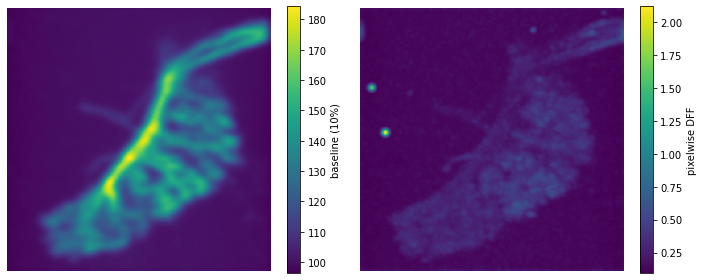

In [11]:
dffMP = np.max(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)
fig.savefig(saveDir+sep+'_'.join(['BaselineAndDFF_MIP',genotype, region, flyID, condition, trial])+'.pdf')

### Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [12]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)
if exists(sep.join([preprocDir,'mask.npy'])):
    mask = np.load(sep.join([preprocDir,'mask.npy'])) 
    viewer.add_labels(mask, opacity=0.2)

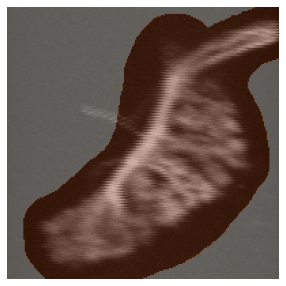

In [19]:
mask = viewer.layers["mask"]
if not exists(sep.join([preprocDir,'mask.npy'])):
    if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
    np.save(sep.join([preprocDir,'mask']), mask.data)
if not exists(sep.join([preprocDir,trial,'mask.npy'])):
    if not exists(sep.join([preprocDir,trial])): makedirs(sep.join([preprocDir,trial]))
    np.save(sep.join([preprocDir,trial,'mask']), mask.data)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, condition, trial])+'.pdf')

In [20]:
# Settings
from sklearn.cluster import KMeans
nclst = 4

toClust = dffStack[:,mask.data>0]
kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [21]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

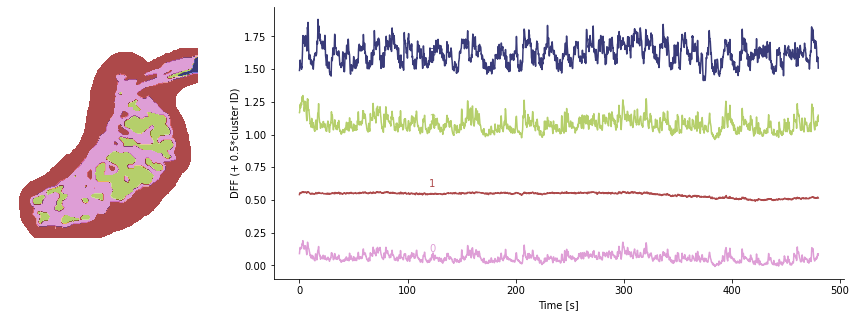

In [22]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,i*0.5+.1,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

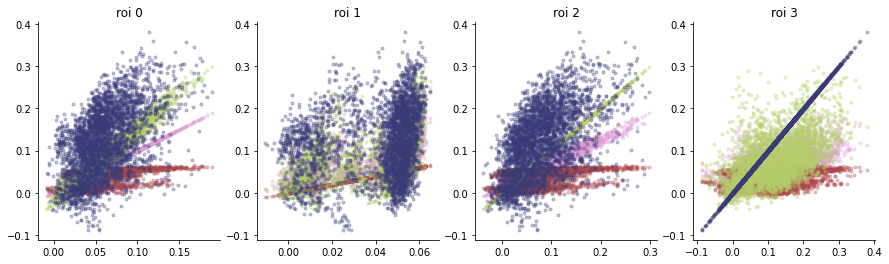

In [23]:
fig, axs = plt.subplots(1,nclst,figsize=(15,4))

for i in range(nclst):
    for j in range(nclst):
        axs[i].plot(centroids[i],centroids[j], '.', color=clstCMap.to_rgba(j+1), alpha=0.3)
    axs[i].set_title('roi {}'.format(i))
    myAxisTheme(axs[i])
    
fig.savefig(saveDir+sep+'_'.join(['ROIcrossCorr_kn{}'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

#### Generate data object and save to disk

In [24]:
backgroundROI = 1
otherROIs = list(range(0,nclst))
otherROIs.remove(backgroundROI)

roiDf = pd.DataFrame(data = centroids[otherROIs].T, columns = ['roi{}'.format(i) for i in range(len(otherROIs))])
roiDf['background'] = centroids[backgroundROI].T
roiDf['time [s]'] = time
roiDf.head()

,roi0,roi1,roi2,background,time [s]
0,0.089809,0.167388,-0.010298,0.040937,0.000000
1,0.102658,0.169809,-0.001743,0.049097,0.136266
2,0.115870,0.182730,0.014082,0.053179,0.272531
3,0.127581,0.201041,0.033888,0.054436,0.408797
4,0.136335,0.222851,0.063653,0.054317,0.545062


In [25]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    refStackMC = np.mean(stackMPMC,axis=0), 
    dffMIP = np.max(dffXarray,axis=0), 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = kmlabsImg, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(ppsaveDir, trial)

In [26]:
# To load data from previously save files into object: 
# imgTS_load = imp.loadImagingTimeseries(path2imgdat)